# Continuous valued detection task

In this version of the task we again have an underlying target variable $M\in\{-1,0,1\}$ and we assume $M\neq 0$ with probability $p_m$ (and $\pm 1$ equally likely in that case). At each time step $t$ we have a latent $E_t$ variable with $p_e=P(E=1|M\neq 0)$ and $P(E=1|M=0)=0$. With this, let $X_{it}$ be channel $i$ at time $t$, then $X_{it}$ has one of two distributions depending on the value of $E_t$. If $E_t=0$ then $X_{it}\sim N(0, 1)$. If $E_t=1$ then $M=\pm 1$ and $X_{it}\sim N(\mu,\sigma^2)$.

As usual, we want to compute $\log P(M|X)$ which is proportional to $\log P(M)+\log P(X|M)$. We also as usual get $\log P(X|M)=\sum_t \log P(X_t|M)$. We sum over the possible $E$ values to get:

$$\log P(X|M)=\sum_t \log \left( P(X_t|M,E=1)P(E=1|M) + P(X_t|M,E=0)P(E=0|M) \right)$$

and then take the product over the channels to get

$$\log P(X|M)=\sum_t \log \left( P(E=1|M) \prod_i P(X_{it}|M,E=1) + P(E=0|M) \prod_i P(X_{it}|M,E=0) \right)$$

Writing $\phi(x,\mu,\sigma)$ for the probability distribution function of an $N(\mu,\sigma^2)$ random variable we get:

$$\log P(X|M)=\sum_t \log \left( P(E=1|M) \prod_i \phi(X_{it},M\mu,\sigma) + P(E=0|M) \prod_i \phi(X_{it}, 0, 1) \right)$$

This is the FTA algorithm for this case. For ATF, we compute $\log P(X_i|M)$ separately for each channel $i$ and then sum them.

In [1]:
from multisensory import *
from collections import namedtuple
from scipy.stats import norm

plt.style.use("./style_sheet.mplstyle")

col = ["xkcd:muted blue", "xkcd:coral pink"]

In [2]:
# This just gives us a nice way to wrap up a bunch of parameters in a single object we can pass around
Params = namedtuple('Params', ['num_trials', 'num_channels', 'num_windows', 'pm', 'pe', 'mu', 'sigma'])

def generate_trials(p):
    M = choice([-1, 0, 1], size=(p.num_trials,), p=[p.pm/2, 1-p.pm, p.pm/2])
    # We choose E values for all trials and windows, but then multiply by 0 where M=0.
    # The output has shape (num_trials, num_channels, num_windows) which we'll want below
    E = np.array(rand(p.num_trials, p.num_windows)[:, None, :]<p.pe*(M!=0)[:, None, None], dtype=float)
    # Now we compute the mean and std for the normal distribution for each point
    mu = p.mu*E*M[:, None, None]
    sigma = 1-E+p.sigma*E
    # Then generate normal random samples according to this
    X = randn(p.num_trials, p.num_channels, p.num_windows)*sigma+mu
    return M, X

In [3]:
# Log likelihood function. The include_prior includes the P(M) term or not. If computing ATF we only want to include the prior
# once, so we set this to on for channel 0 and off for the remaining channels.
def LL(X, p, include_prior=True):
    # X has shape (num_trials, num_channels, num_windows)
    ll = np.zeros((p.num_trials, 3))
    for m in [-1, 0, 1]:
        pem = p.pe*(m!=0) # this variable represents P(E=1|M)
        if include_prior:
            ll[:, m+1] = np.log(p.pm/2) if m!=0 else np.log(1-p.pm)
        p0 = norm.pdf(X, 0, 1)
        p1 = norm.pdf(X, m*p.mu, p.sigma)
        # prod(axis=1) does the product across channels. THe output of that has shape (num_trials, num_windows) so
        # the sum(axis=1) then sums across the windows.
        ll[:, m+1] += (np.log(p0.prod(axis=1)*(1-pem)+p1.prod(axis=1)*pem)).sum(axis=1)
    return ll

In [4]:
def fta_accuracy(params):
    M, X = generate_trials(params)
    ll = LL(X, params)
    # This gives the accuracy because it's the sum of the number of times M=best guess divided by the number of trials.
    accuracy = (M==ll.argmax(axis=1)-1).mean()
    return accuracy

def atf_accuracy(params):
    M, X = generate_trials(params)
    ll = np.zeros((params.num_trials, 3))
    for i in range(params.num_channels):
        # The idea here is we use the same log likelihood formula, but only for a single channel (so channel i only, but to make shapes match we use i:i+1)
        # We only include the prior for channel 0 so as not to count it multiple times
        ll += LL(X[:, i:i+1, :], params, include_prior=i==0)
    accuracy = (M==ll.argmax(axis=1)-1).mean()
    return accuracy


2.0999999999999943


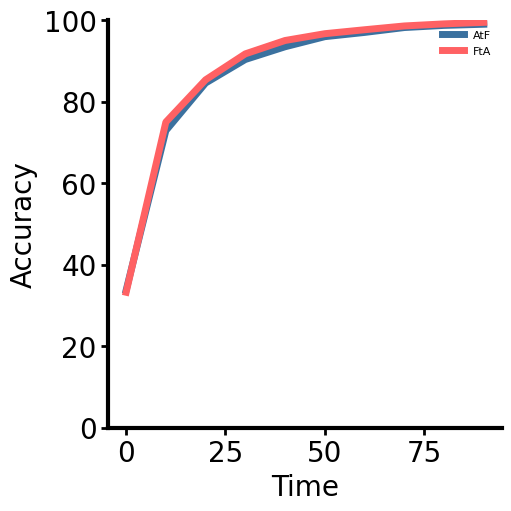

In [5]:
# Dense
N_range = np.arange(0, 90+1, 10)
fta = []
atf = []
for N in N_range:
    params = Params(num_trials=10000, num_channels=5, num_windows=N, pm=2/3, pe=0.5, mu=0.5, sigma=1.0)
    fta.append(fta_accuracy(params) * 100)
    atf.append(atf_accuracy(params) * 100)
fta = np.array(fta)
atf = np.array(atf)
print((fta-atf).max())

plt.subplots(constrained_layout=True)
plt.plot(N_range, atf, c=col[0], linewidth=5, label='AtF')
plt.plot(N_range, fta, c=col[1], linewidth=5, label='FtA')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.savefig('continuous_0.svg')

23.439999999999984


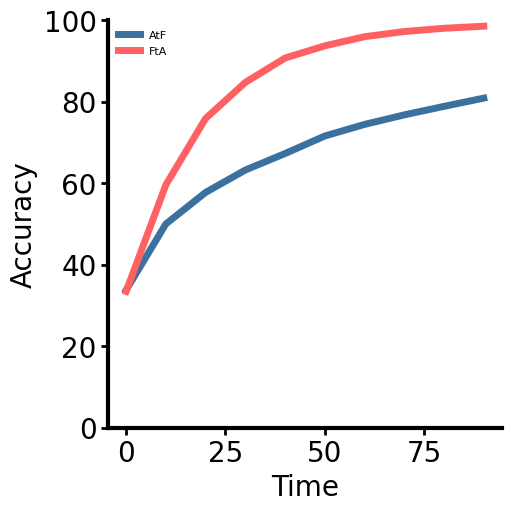

In [6]:
# Sparse
N_range = np.arange(0, 90+1, 10)
fta = []
atf = []
for N in N_range:
    params = Params(num_trials=10000, num_channels=5, num_windows=N, pm=2/3, pe=0.05, mu=0.5, sigma=0.1)
    fta.append(fta_accuracy(params) * 100)
    atf.append(atf_accuracy(params) * 100)
fta = np.array(fta)
atf = np.array(atf)
print((fta-atf).max())

plt.subplots(constrained_layout=True)
plt.plot(N_range, atf, c=col[0], linewidth=5, label='AtF')
plt.plot(N_range, fta, c=col[1], linewidth=5, label='FtA')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.savefig('continuous_1.svg')